In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import make_column_transformer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.utils import class_weight
from imblearn.over_sampling  import SMOTE
import xgboost
from sklearn.utils import class_weight
from keras.models import Sequential, Model
from keras.layers import Dense
from keras.layers import Dropout, Input, Embedding, Reshape, Concatenate, Activation, LeakyReLU, BatchNormalization
from keras.callbacks import EarlyStopping
import time

Using TensorFlow backend.


In [2]:
def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    fig, ax = plt.subplots(figsize=(10,10))
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax

In [3]:
raw_data = pd.read_csv('final_wth_outliners_plus.csv')
raw_data = raw_data.drop(['Unnamed: 0'], axis=1)
raw_data.head()


,Nombre pieces principales,Surface reelle bati,Valeur fonciere,Code postal,Code type local,year,month,day,P15_POP,MED14,nombre de redevables,Typo degré de densité,Part population dense (1),Part population intermédiaire (2),Part population peu dense (3),Part population très peu dense (4),Longitude,Latitude,€/m2
0,2,50,240000,83640,1,2014,1,1,7459.0,22316.0,0.0,2.277,0.0,0.624,0.364,0.012,5.717,43.333,4800.000000
1,3,87,43000,16700,1,2014,1,1,9611.0,18267.0,0.0,3.274,0.0,0.000,0.707,0.293,0.162,45.959,494.252874
2,2,50,240000,83640,1,2014,1,1,7459.0,22316.0,0.0,2.277,0.0,0.624,0.364,0.012,5.717,43.333,4800.000000
3,4,74,73000,9220,1,2014,1,2,1157.0,18233.0,0.0,3.086,0.0,0.000,0.865,0.135,1.564,42.764,986.486486
4,5,92,150000,80500,1,2014,1,2,12900.0,18641.0,0.0,2.698,0.0,0.450,0.354,0.197,2.567,49.650,1630.434783


In [4]:
Y = raw_data['Nombre pieces principales']
Y = list(Y)
df= raw_data.copy()
for i, m in enumerate(Y):
    if m >= 7:
        Y[i] = 7
    elif m<=1:
        Y[i] = 1

df.drop('Nombre pieces principales', axis = 1, inplace = True)
df.insert(loc=0, column='Nombre pieces principales', value=Y)

del Y
df.head()

,Nombre pieces principales,Surface reelle bati,Valeur fonciere,Code postal,Code type local,year,month,day,P15_POP,MED14,nombre de redevables,Typo degré de densité,Part population dense (1),Part population intermédiaire (2),Part population peu dense (3),Part population très peu dense (4),Longitude,Latitude,€/m2
0,2,50,240000,83640,1,2014,1,1,7459.0,22316.0,0.0,2.277,0.0,0.624,0.364,0.012,5.717,43.333,4800.000000
1,3,87,43000,16700,1,2014,1,1,9611.0,18267.0,0.0,3.274,0.0,0.000,0.707,0.293,0.162,45.959,494.252874
2,2,50,240000,83640,1,2014,1,1,7459.0,22316.0,0.0,2.277,0.0,0.624,0.364,0.012,5.717,43.333,4800.000000
3,4,74,73000,9220,1,2014,1,2,1157.0,18233.0,0.0,3.086,0.0,0.000,0.865,0.135,1.564,42.764,986.486486
4,5,92,150000,80500,1,2014,1,2,12900.0,18641.0,0.0,2.698,0.0,0.450,0.354,0.197,2.567,49.650,1630.434783


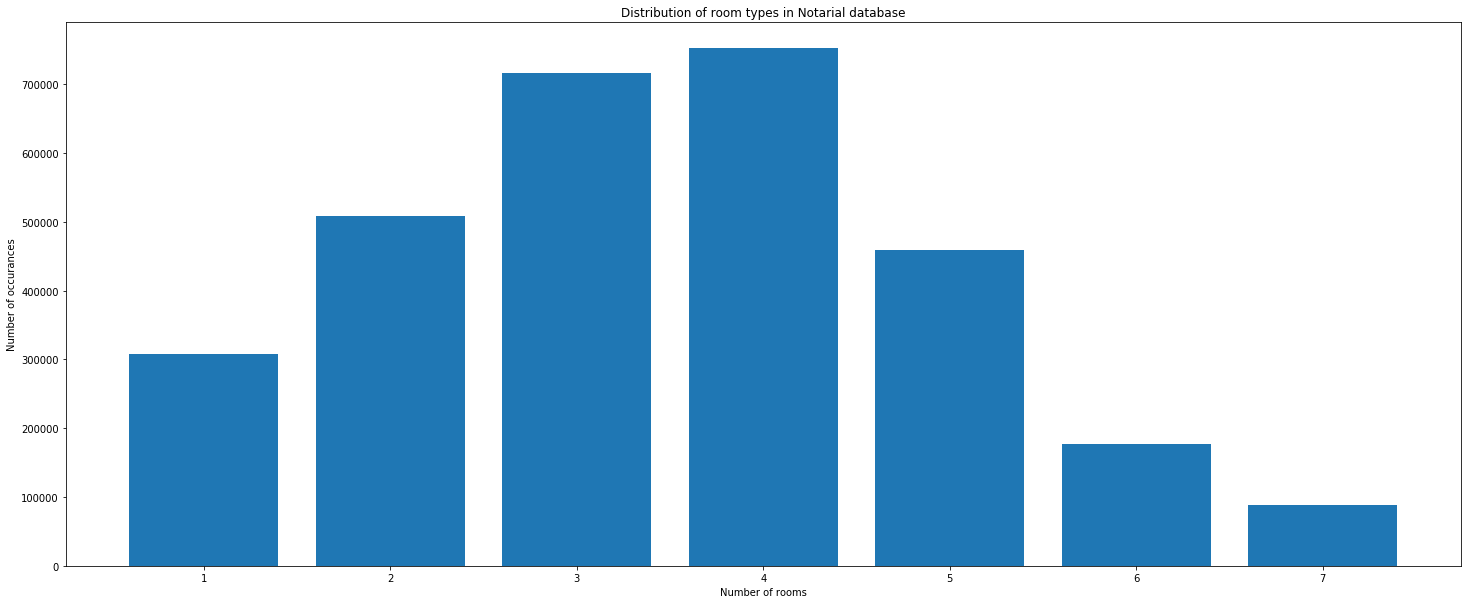

In [5]:
Y = df['Nombre pieces principales']

plt.figure(figsize=(25,10))
bars = plt.bar(Y.value_counts().index, list(Y.value_counts()))

i = 0
for rect in bars:
    if rect.get_height() < 5000:
        h = 20000**(i%2)
        height = rect.get_height()
        plt.text(rect.get_x() + rect.get_width()/2.0, height+h, '%d' % int(height), ha='center', va='bottom')
        i += 1

plt.xlabel('Number of rooms')
plt.ylabel('Number of occurances')
plt.title('Distribution of room types in Notarial database')
#plt.grid(True)
plt.xticks(Y.value_counts().index)
#plt.savefig('Distribution of room types in Notarial database.png', dpi=200)
plt.show()
plt.close()

del Y

In [6]:
targets =  pd.get_dummies(df['Nombre pieces principales']).values
inputs_stdsc =df[['Valeur fonciere', 'Code type local',
                        'year', 'month', 'day', 'P15_POP', 'MED14','Part population dense (1)',
                        'Part population intermédiaire (2)', 'Part population peu dense (3)',
                        'Part population très peu dense (4)', 'Longitude', 'Latitude']].values
inputs_mmsc = df[['Surface reelle bati','nombre de redevables','Typo degré de densité']].values

In [7]:
sc = StandardScaler()
mms= MinMaxScaler()
inputs_stdsc = sc.fit_transform(inputs_stdsc)
inputs_mmsc = mms.fit_transform(inputs_mmsc)

In [8]:
codes_postaux = raw_data['Code postal'].values

In [9]:
inputs_stdsc.shape[1]+inputs_mmsc.shape[1]

16

In [10]:
raw_data.columns

Index(['Nombre pieces principales', 'Surface reelle bati', 'Valeur fonciere',
       'Code postal', 'Code type local', 'year', 'month', 'day', 'P15_POP',
       'MED14', 'nombre de redevables', 'Typo degré de densité',
       'Part population dense (1)', 'Part population intermédiaire (2)',
       'Part population peu dense (3)', 'Part population très peu dense (4)',
       'Longitude', 'Latitude', '€/m2'],
      dtype='object')

In [11]:
cols_to_use = ['Code postal','Valeur fonciere', 'Code type local',
                        'year', 'month', 'day', 'P15_POP', 'MED14','Part population dense (1)',
                        'Part population intermédiaire (2)', 'Part population peu dense (3)',
                        'Part population très peu dense (4)', 'Longitude', 'Latitude','Surface reelle bati','nombre de redevables','Typo degré de densité']

In [12]:
len(cols_to_use)

17

In [13]:
scaled_values = np.concatenate((np.reshape(codes_postaux,(-1,1)),inputs_stdsc, inputs_mmsc), axis=1)

In [14]:
scaled_data = pd.DataFrame(data=scaled_values, columns = cols_to_use)

In [15]:
scaled_data.head()

,Code postal,Valeur fonciere,Code type local,year,month,day,P15_POP,MED14,Part population dense (1),Part population intermédiaire (2),Part population peu dense (3),Part population très peu dense (4),Longitude,Latitude,Surface reelle bati,nombre de redevables,Typo degré de densité
0,83640.0,0.136034,-0.860984,-1.479004,-1.539765,-1.817773,-0.532210,0.414741,-0.730868,0.962523,0.109436,-0.423955,1.287854,-1.547021,0.037433,0.0,0.425667
1,16700.0,-0.798037,-0.860984,-1.479004,-1.539765,-1.817773,-0.503743,-0.704037,-0.730868,-0.769790,1.071435,1.590199,-0.796124,-0.394445,0.065699,0.0,0.758000
2,83640.0,0.136034,-0.860984,-1.479004,-1.539765,-1.817773,-0.532210,0.414741,-0.730868,0.962523,0.109436,-0.423955,1.287854,-1.547021,0.037433,0.0,0.425667
3,9220.0,-0.655793,-0.860984,-1.479004,-1.539765,-1.705934,-0.615573,-0.713432,-0.730868,-0.769790,1.514572,0.457685,-0.270159,-1.796760,0.055768,0.0,0.695333
4,80500.0,-0.290699,-0.860984,-1.479004,-1.539765,-1.705934,-0.460236,-0.600697,-0.730868,0.479474,0.081389,0.902089,0.106120,1.225569,0.069519,0.0,0.566000


In [16]:
X_train, X_test, y_train, y_test = train_test_split(scaled_values, targets, test_size=0.1, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=(1/9), random_state=42)

In [17]:
X_train = pd.DataFrame(X_train, columns=cols_to_use)
X_val = pd.DataFrame(X_val, columns=cols_to_use)
X_test = pd.DataFrame(X_test, columns=cols_to_use)

In [18]:
embed_cols = ['Code postal']

In [19]:
def preproc(X_train, X_val, X_test):

    input_list_train = []
    input_list_val = []
    input_list_test = []
    
    #the cols to be embedded: rescaling to range [0, # values)
    for c in embed_cols:
        raw_vals = np.unique(X_train[c])
        val_map = {}
        for i in range(len(raw_vals)):
            val_map[raw_vals[i]] = i       
        input_list_train.append(X_train[c].map(val_map).values)
        input_list_val.append(X_val[c].map(val_map).fillna(0).values)
        input_list_test.append(X_test[c].map(val_map).fillna(0).values)
     
    #the rest of the columns
    other_cols = [c for c in X_train.columns if (not c in embed_cols)]
    input_list_train.append(X_train[other_cols].values)
    input_list_val.append(X_val[other_cols].values)
    input_list_test.append(X_test[other_cols].values)
    
    return input_list_train, input_list_val, input_list_test 



input_list_train, input_list_val, input_list_test= preproc(X_train, X_val, X_test)

In [20]:
num_numeric_values = inputs_mmsc.shape[1]+inputs_stdsc.shape[1]

In [21]:
num_numeric_values

16

In [22]:
def NN_model(hidden_layers, size_hl):
    inputs=[]
    embeddings = []
    for categorical_var in embed_cols :
     
        no_of_unique_cat  = X_train[categorical_var].nunique()
        embedding_size = min(np.ceil((no_of_unique_cat)/2), 50 )
        embedding_size = int(embedding_size)
        vocab  = no_of_unique_cat+1
        input_cat =  Input(shape=(1,))
        embedding = Embedding(vocab ,embedding_size, input_length = 1 )(input_cat)
        embedding = Reshape(target_shape=(embedding_size,))(embedding)
        inputs.append(input_cat)
        embeddings.append(embedding)

    input_numeric = Input(shape=(num_numeric_values,))
    embedding_numeric = Dense(16)(input_numeric) 
    inputs.append(input_numeric)
    embeddings.append(embedding_numeric)
    
    x = Concatenate()(embeddings)
    
    for hidden_layer in range(hidden_layers):
        if hidden_layer==1:
            x = Dense(int(size_hl*(1.75)), activation='linear')(x)
            x = Activation(LeakyReLU(0.05))(x)
            x = Dropout(.1)(x)
            x = BatchNormalization()(x)
        else:
            if hidden_layer%2==0:
                x = Dense(int(size_hl*(1.5)), activation='linear')(x)
                x = Activation(LeakyReLU(0.05))(x)
                x = Dropout(.1)(x)
                x = BatchNormalization()(x)
            elif hidden_layer%2==1:
                x = Dense(int(size_hl*0.5), activation='linear')(x)
                x = Activation(LeakyReLU(0.05))(x)
                x = Dropout(.1)(x)
                x = BatchNormalization()(x)
            
        
    output = Dense(7, activation='softmax')(x)
    model = Model(inputs, output)    
    model.compile(loss='categorical_crossentropy', optimizer='adam',metrics=['accuracy'])
    return model


In [28]:
model = NN_model(hidden_layers=2, size_hl=200)


model.fit(input_list_train,y_train,
          epochs=4, batch_size=32,validation_data=(input_list_val,y_val),
          verbose=2)



C:\Users\cmorv\Anaconda3\lib\site-packages\keras\activations.py:211: UserWarning: Do not pass a layer instance (such as LeakyReLU) as the activation argument of another layer. Instead, advanced activation layers should be used just like any other layer in a model.
  identifier=identifier.__class__.__name__))
C:\Users\cmorv\Anaconda3\lib\site-packages\keras\activations.py:211: UserWarning: Do not pass a layer instance (such as LeakyReLU) as the activation argument of another layer. Instead, advanced activation layers should be used just like any other layer in a model.
  identifier=identifier.__class__.__name__))


Train on 2409246 samples, validate on 301156 samples
Epoch 1/4
 - 1166s - loss: 1.1044 - acc: 0.5283 - val_loss: 1.0605 - val_acc: 0.5453
Epoch 2/4
 - 753s - loss: 1.0570 - acc: 0.5514 - val_loss: 1.0365 - val_acc: 0.5594
Epoch 3/4
 - 765s - loss: 1.0467 - acc: 0.5562 - val_loss: 1.0360 - val_acc: 0.5603
Epoch 4/4
 - 767s - loss: 1.0398 - acc: 0.5593 - val_loss: 1.0372 - val_acc: 0.5594


In [29]:
sns.set_style(style='white')

In [30]:
y_pred = model.predict(input_list_test)

Normalized confusion matrix
[[6.48494289e-01 2.87902388e-01 4.11799065e-02 1.59657321e-02
  5.51661475e-03 9.73520249e-05 8.43717549e-04]
 [8.51962683e-02 6.47303878e-01 2.19347142e-01 4.16984490e-02
  6.31735414e-03 3.91167439e-05 9.77918598e-05]
 [3.80212133e-03 1.18146361e-01 5.60805881e-01 2.76544699e-01
  3.90594309e-02 6.17318593e-04 1.02418766e-03]
 [1.15199746e-03 6.11750374e-03 1.57836893e-01 6.26792548e-01
  1.98514321e-01 3.52219912e-03 6.06453834e-03]
 [2.40431477e-03 5.19851842e-04 2.72489007e-02 4.06047610e-01
  5.14978231e-01 2.01442589e-02 2.86568328e-02]
 [6.01133566e-03 1.14501632e-04 6.92734871e-03 1.51943665e-01
  6.60101906e-01 6.62391939e-02 1.08662048e-01]
 [1.28701595e-02 9.11161731e-04 1.70842825e-03 4.21412301e-02
  4.71981777e-01 1.01366743e-01 3.69020501e-01]]


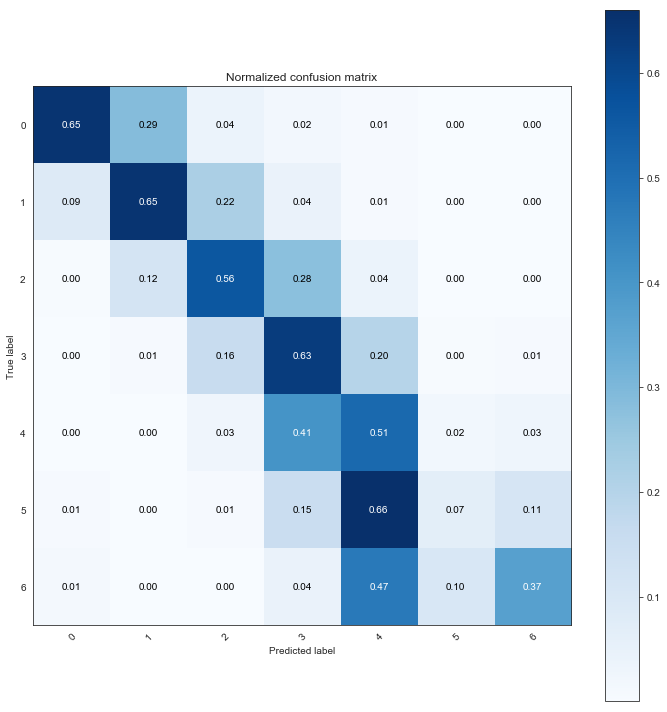

In [31]:


plot_confusion_matrix(y_test.argmax(axis=1), y_pred.argmax(axis=1), classes=list(np.unique(y_train.argmax(axis=1))), normalize=True, title='Normalized confusion matrix')
plt.show()

In [23]:
y = y_train.argmax(axis=1)

class_weights = class_weight.compute_class_weight('balanced',
                                                  np.unique(y),
                                                  y)

# Convert class_weights to a dictionary to pass it to class_weight in model.fit
class_weights = dict(enumerate(class_weights))

In [24]:
class_weights[4] +=1.2
class_weights[5] += 2.5
class_weights[6] += 4

In [25]:
class_weights

{0: 1.3941387341772151,
 1: 0.8469467856044294,
 2: 0.600008367879893,
 3: 0.5716131582400098,
 4: 2.13789138076682,
 5: 4.927909339089581,
 6: 8.811793982775976}

In [26]:
model_bis = NN_model(hidden_layers=2, size_hl=200)


model_bis.fit(input_list_train,y_train,
          epochs=9, batch_size=32,validation_data=(input_list_val,y_val),
          verbose=2, class_weight=class_weights)

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


C:\Users\cmorv\Anaconda3\lib\site-packages\keras\activations.py:211: UserWarning: Do not pass a layer instance (such as LeakyReLU) as the activation argument of another layer. Instead, advanced activation layers should be used just like any other layer in a model.
  identifier=identifier.__class__.__name__))
C:\Users\cmorv\Anaconda3\lib\site-packages\keras\activations.py:211: UserWarning: Do not pass a layer instance (such as LeakyReLU) as the activation argument of another layer. Instead, advanced activation layers should be used just like any other layer in a model.
  identifier=identifier.__class__.__name__))


Instructions for updating:
Use tf.cast instead.
Train on 2409246 samples, validate on 301156 samples
Epoch 1/9
 - 957s - loss: 1.6804 - acc: 0.4502 - val_loss: 1.1733 - val_acc: 0.4922
Epoch 2/9
 - 920s - loss: 1.6073 - acc: 0.4807 - val_loss: 1.1320 - val_acc: 0.5040
Epoch 3/9
 - 918s - loss: 1.5898 - acc: 0.4875 - val_loss: 1.1138 - val_acc: 0.5160
Epoch 4/9
 - 917s - loss: 1.5790 - acc: 0.4916 - val_loss: 1.1615 - val_acc: 0.4976
Epoch 5/9
 - 914s - loss: 1.5716 - acc: 0.4948 - val_loss: 1.1709 - val_acc: 0.4994
Epoch 6/9
 - 918s - loss: 1.5646 - acc: 0.4969 - val_loss: 1.1421 - val_acc: 0.5049
Epoch 7/9
 - 911s - loss: 1.5596 - acc: 0.4989 - val_loss: 1.1591 - val_acc: 0.5036
Epoch 8/9
 - 957s - loss: 1.5551 - acc: 0.5008 - val_loss: 1.1954 - val_acc: 0.4865
Epoch 9/9
 - 2250s - loss: 1.5508 - acc: 0.5022 - val_loss: 1.1881 - val_acc: 0.4866


Normalized confusion matrix
[[7.85014278e-01 1.56606957e-01 3.50791796e-02 3.89408100e-03
  1.25259605e-02 4.57554517e-03 2.30399792e-03]
 [1.83887813e-01 5.87259677e-01 1.84474564e-01 1.04832874e-02
  2.81836140e-02 4.34195858e-03 1.36908604e-03]
 [1.37914586e-02 1.35305012e-01 5.75621528e-01 8.57090746e-02
  1.57570571e-01 2.51276727e-02 6.87468433e-03]
 [1.53599661e-03 7.71970710e-03 1.94502191e-01 1.78440434e-01
  4.72716198e-01 1.11452444e-01 3.36330292e-02]
 [1.06136418e-03 8.01438257e-04 3.06712587e-02 3.60214006e-02
  5.27822904e-01 2.81304828e-01 1.22316806e-01]
 [1.71752447e-03 2.86254079e-04 6.35484056e-03 4.75181771e-03
  2.28717009e-01 4.35735959e-01 3.22436595e-01]
 [2.73348519e-03 6.83371298e-04 1.82232346e-03 1.82232346e-03
  6.27562642e-02 2.53189066e-01 6.76993166e-01]]


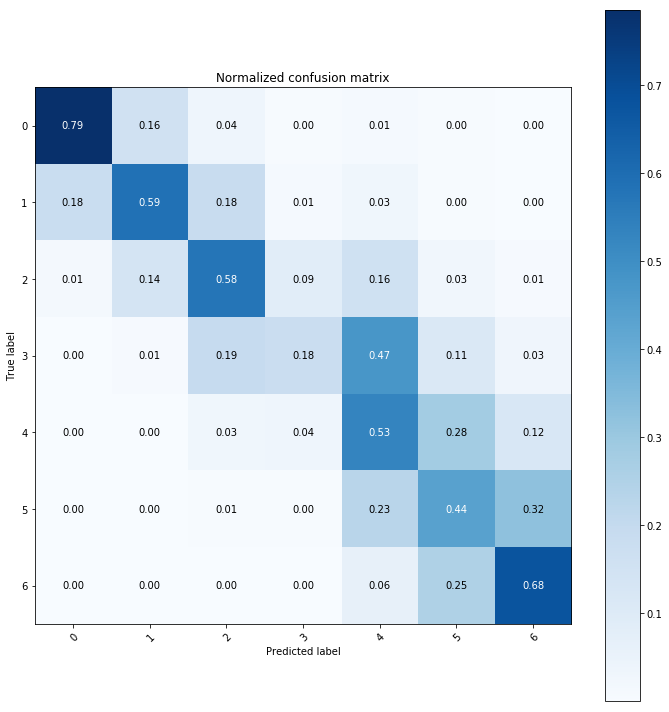

In [27]:
y_pred_bis = model_bis.predict(input_list_test)
plot_confusion_matrix(y_test.argmax(axis=1), y_pred_bis.argmax(axis=1), classes=list(np.unique(y_train.argmax(axis=1))), normalize=True, title='Normalized confusion matrix')
plt.show()

In [32]:
y_pred_1 = model.predict(input_list_test)
y_pred_2 = model_bis.predict(input_list_test)


Normalized confusion matrix
[[7.27089823e-01 2.12746625e-01 3.84215992e-02 1.01246106e-02
  8.50207684e-03 1.42782970e-03 1.68743510e-03]
 [1.26405758e-01 6.27178314e-01 2.02077099e-01 2.68536447e-02
  1.55097890e-02 1.36908604e-03 6.06309531e-04]
 [6.41169538e-03 1.27364050e-01 5.75846007e-01 1.84213480e-01
  9.60211011e-02 6.86065436e-03 3.28301251e-03]
 [1.12551476e-03 6.64715774e-03 1.79036295e-01 4.00511116e-01
  3.56629282e-01 3.91546722e-02 1.68959627e-02]
 [1.79782095e-03 6.93135790e-04 3.04546538e-02 1.52489874e-01
  6.11692334e-01 1.31717461e-01 7.11547209e-02]
 [4.23656037e-03 1.14501632e-04 7.21360279e-03 3.59535123e-02
  4.42491556e-01 2.90433389e-01 2.19556879e-01]
 [6.26423690e-03 7.97266515e-04 2.27790433e-03 9.22551253e-03
  1.89977221e-01 2.33029613e-01 5.58428246e-01]]


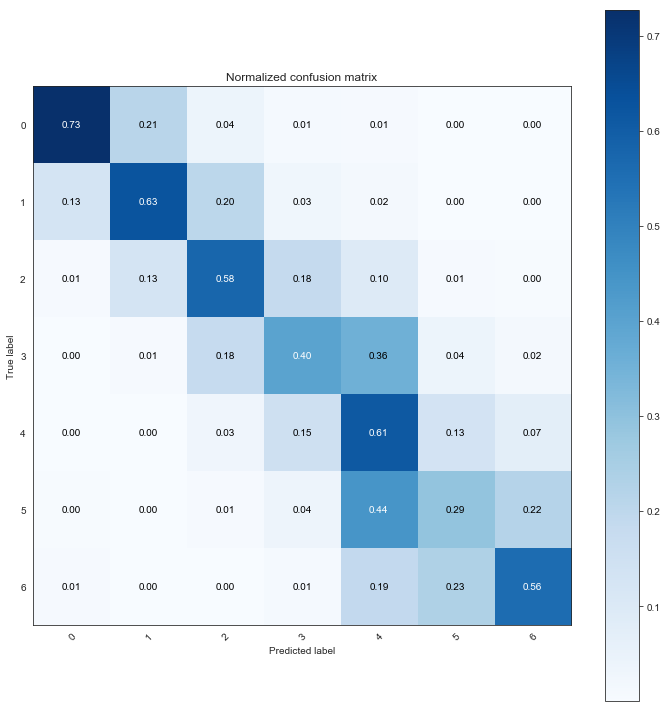

In [41]:
y_pred_final = 0.5*y_pred_1+0.5*y_pred_2
plot_confusion_matrix(y_test.argmax(axis=1), y_pred_final.argmax(axis=1), classes=list(np.unique(y_train.argmax(axis=1))), normalize=True, title='Normalized confusion matrix')
plt.show()

In [42]:
from sklearn.metrics import classification_report
print(classification_report(y_test.argmax(axis=1), y_pred_final.argmax(axis=1)))

              precision    recall  f1-score   support

           0       0.76      0.73      0.74     30816
           1       0.66      0.63      0.65     51129
           2       0.61      0.58      0.59     71276
           3       0.57      0.40      0.47     75521
           4       0.39      0.61      0.48     46167
           5       0.30      0.29      0.30     17467
           6       0.36      0.56      0.44      8780

   micro avg       0.54      0.54      0.54    301156
   macro avg       0.52      0.54      0.52    301156
weighted avg       0.57      0.54      0.55    301156



In [ ]:
def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    fig, ax = plt.subplots(figsize=(10,10))
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax

Normalized confusion matrix
[[7.40452312e-01 1.96614845e-01 3.99724130e-02 1.61498894e-02
  5.43119055e-03 4.02310411e-04 9.77039570e-04]
 [1.30795367e-01 6.15158379e-01 2.02422272e-01 4.51755508e-02
  6.19268569e-03 1.27872566e-04 1.27872566e-04]
 [5.09428323e-03 1.13048903e-01 5.83542346e-01 2.62420564e-01
  3.45423592e-02 9.22689054e-04 4.28855476e-04]
 [9.81079187e-04 5.45327133e-03 1.67446009e-01 6.39026566e-01
  1.80161814e-01 4.63782888e-03 2.29343187e-03]
 [1.54031186e-03 7.80706011e-04 2.29780769e-02 4.36499061e-01
  5.04103982e-01 2.24505729e-02 1.16472897e-02]
 [4.59136823e-03 1.62048290e-04 4.05120726e-03 1.82736455e-01
  6.71312051e-01 8.65337871e-02 5.06130827e-02]
 [2.78805121e-02 6.63821716e-04 2.27596017e-03 5.20625889e-02
  5.02607871e-01 1.44238976e-01 2.70270270e-01]]


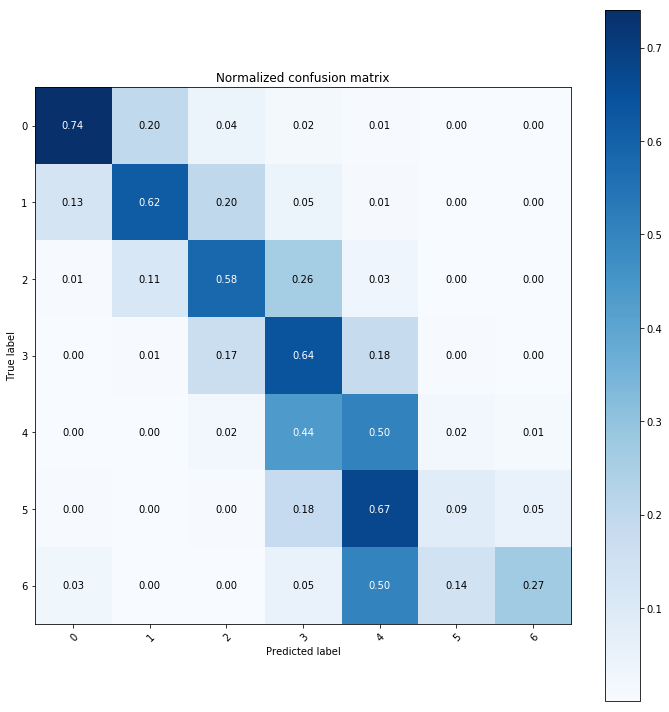

In [31]:
y_pred = model.predict(input_list_test)

plot_confusion_matrix(y_test.argmax(axis=1), y_pred.argmax(axis=1), classes=list(np.unique(y_train.argmax(axis=1))), normalize=True, title='Normalized confusion matrix')
plt.show()

In [ ]:
y_pred = model.predict(input_list_test)

In [29]:
y_pred.argmax(axis=1)

array([2, 2, 3, ..., 2, 3, 3], dtype=int64)

In [22]:
y = y_train.argmax(axis=1)

class_weights = class_weight.compute_class_weight('balanced',
                                                  np.unique(y),
                                                  y)

# Convert class_weights to a dictionary to pass it to class_weight in model.fit
class_weights = dict(enumerate(class_weights))

In [23]:
weights = list(np.arange(4,7))

In [55]:
for weight in weights:
    if weight>=5:
        class_weights[weight] +=1
    else:
        class_weights[weight] +=0.5

In [24]:
class_weights[5] += 2
class_weights[6] += 2

In [25]:
model_bis = NN_model(hidden_layers=2, size_hl=200)


model_bis.fit(input_list_train,y_train,
          epochs=3, batch_size=32,validation_data=(input_list_val,y_val),
          verbose=2, class_weight=class_weights)

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


C:\Users\cmorv\Anaconda3\lib\site-packages\keras\activations.py:211: UserWarning: Do not pass a layer instance (such as LeakyReLU) as the activation argument of another layer. Instead, advanced activation layers should be used just like any other layer in a model.
  identifier=identifier.__class__.__name__))
C:\Users\cmorv\Anaconda3\lib\site-packages\keras\activations.py:211: UserWarning: Do not pass a layer instance (such as LeakyReLU) as the activation argument of another layer. Instead, advanced activation layers should be used just like any other layer in a model.
  identifier=identifier.__class__.__name__))


Instructions for updating:
Use tf.cast instead.
Train on 2409246 samples, validate on 301156 samples
Epoch 1/3
 - 598s - loss: 1.3413 - acc: 0.4640 - val_loss: 1.1983 - val_acc: 0.4929
Epoch 2/3
 - 611s - loss: 1.2795 - acc: 0.4934 - val_loss: 1.1823 - val_acc: 0.4932
Epoch 3/3
 - 614s - loss: 1.2661 - acc: 0.4992 - val_loss: 1.1530 - val_acc: 0.5027


Normalized confusion matrix
[[7.43152908e-01 1.97365005e-01 3.67341641e-02 1.19742991e-02
  1.59008307e-03 7.46365524e-03 1.71988577e-03]
 [1.42619648e-01 6.45465391e-01 1.69062567e-01 2.78315633e-02
  1.91672045e-03 1.25955915e-02 5.08517671e-04]
 [5.93467647e-03 1.70688591e-01 5.62699927e-01 1.78054324e-01
  1.21639823e-02 6.78348953e-02 2.62360402e-03]
 [8.34205056e-04 9.03060076e-03 2.13026840e-01 4.38593239e-01
  6.13604163e-02 2.63171833e-01 1.39828657e-02]
 [8.66419737e-04 9.53061711e-04 3.20358698e-02 2.33716724e-01
  1.07327745e-01 5.63367774e-01 6.17324063e-02]
 [1.66027366e-03 2.29003263e-04 6.06858648e-03 4.88349459e-02
  3.41787370e-02 7.12944409e-01 1.96084044e-01]
 [2.39179954e-03 9.11161731e-04 2.16400911e-03 1.23006834e-02
  6.26423690e-03 4.50000000e-01 5.25968109e-01]]


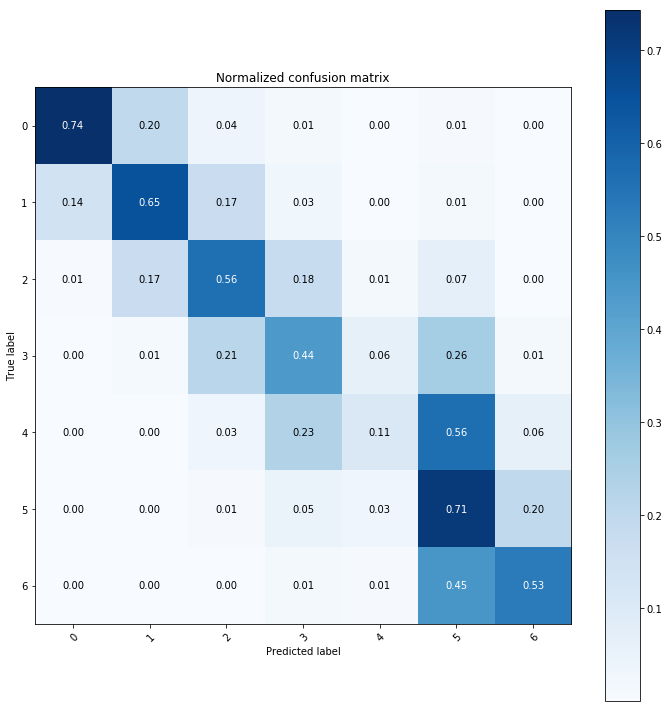

In [28]:
y_pred = model_bis.predict(input_list_test)

plot_confusion_matrix(y_test.argmax(axis=1), y_pred.argmax(axis=1), classes=list(np.unique(y_train.argmax(axis=1))), normalize=True, title='Normalized confusion matrix')
plt.show()

In [22]:
def typo_densite(valeur):
    if valeur<=1.3:
        typo=1
    elif (valeur>1.3)&(valeur<=2.3):
        typo=2
    elif (valeur>2.3)&(valeur<=3.3):
        typo=3
    else:
        typo=4
    return typo

In [23]:
df = raw_data.copy()
df['degre'] = df['Typo degré de densité'].apply(typo_densite)

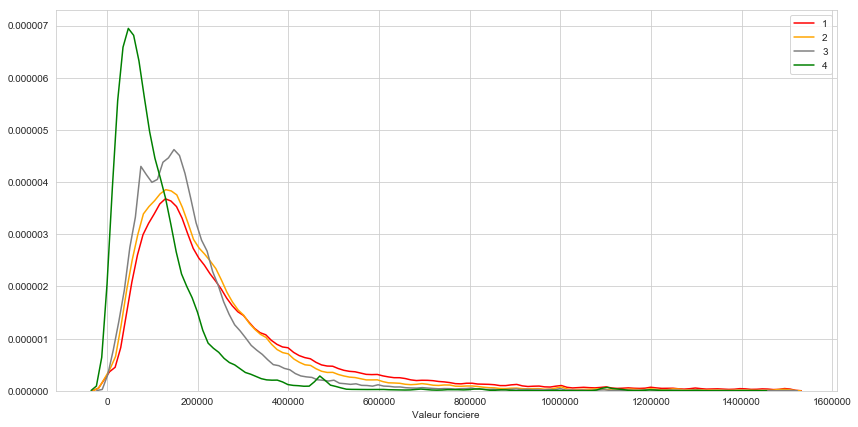

In [38]:
sns.set_style('whitegrid')
plt.figure(figsize=(14,7))
a = 0.3
couleur = ['r','orange','grey','green']
for i, degre in enumerate([1,2,3,4]):
    sns.distplot(df[(df['Typo degré de densité']==degre)&
                   (df['Valeur fonciere']<=1500000)]['Valeur fonciere'], color=couleur[i],
                label = str(degre), hist=False)
plt.legend()


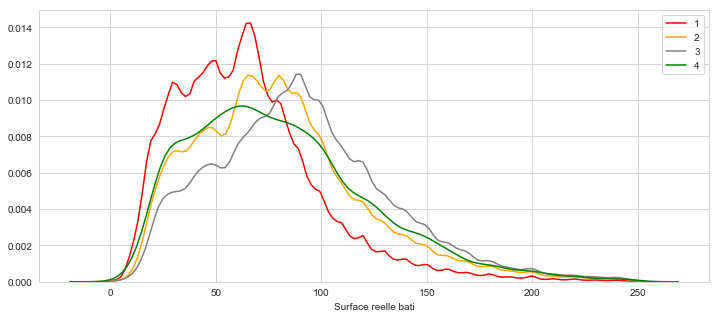

In [35]:
sns.set_style('whitegrid')
plt.figure(figsize=(12,5))
a = 0.3
couleur = ['r','orange','grey','green']
for i, degre in enumerate([1,2,3,4]):
    sns.distplot(df[(df['Typo degré de densité']==degre)&
                   (df['Valeur fonciere']<=1500000)]['Surface reelle bati'], color=couleur[i],
                label = str(degre), hist=False)
plt.legend()

In [30]:
df['€/m2'] = df['Valeur fonciere']/df['Surface reelle bati']

C:\Users\cmorv\Anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


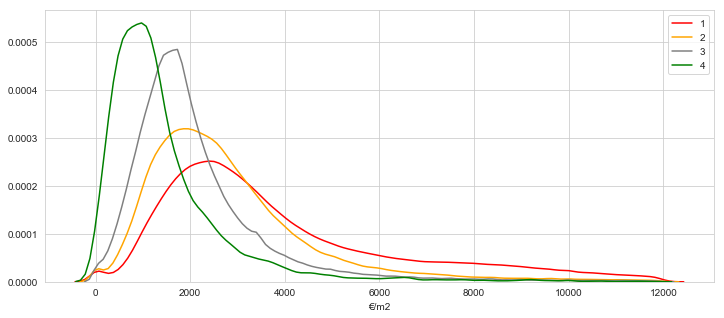

In [34]:
sns.set_style('whitegrid')
plt.figure(figsize=(12,5))
a = 0.3
couleur = ['r','orange','grey','green']
for i, degre in enumerate([1,2,3,4]):
    sns.distplot(df[(df['Typo degré de densité']==degre)&
                   (df['Valeur fonciere']<=1500000)&
                   (df['€/m2']<12000)]['€/m2'], color=couleur[i],
                label = str(degre), hist=False)
plt.legend()

In [51]:
from keras.layers import Input, Dense, Lambda, Flatten, Reshape, Layer
from keras.layers import Conv2D, Conv2DTranspose
from keras.models import Model
from keras import backend as K
from keras import metrics



In [53]:
X_train.columns

Index(['Code postal', 'Valeur fonciere', 'Code type local', 'year', 'month',
       'day', 'P15_POP', 'MED14', 'Part population dense (1)',
       'Part population intermédiaire (2)', 'Part population peu dense (3)',
       'Part population très peu dense (4)', 'Longitude', 'Latitude',
       'Surface reelle bati', 'nombre de redevables', 'Typo degré de densité'],
      dtype='object')

In [54]:
test = X_train[['Valeur fonciere', 'Code type local', 'year', 'month',
       'day', 'P15_POP', 'MED14', 'Part population dense (1)',
       'Part population intermédiaire (2)', 'Part population peu dense (3)',
       'Part population très peu dense (4)', 'Longitude', 'Latitude',
       'Surface reelle bati', 'nombre de redevables', 'Typo degré de densité']]

In [56]:
input_shape = test.shape[1]
intermediate_dim = int(input_shape/2)
latent_dim=2

inputs = Input(shape=(input_shape,), name='encoder_input')
x = Dense(intermediate_dim, activation='relu')(inputs)
z_mean = Dense(latent_dim, name='z_mean')(x)
z_log_var = Dense(latent_dim, name='z_log_var')(x)


def sampling(args):
    """Reparameterization trick by sampling fr an isotropic unit Gaussian.

    # Arguments
        args (tensor): mean and log of variance of Q(z|X)

    # Returns
        z (tensor): sampled latent vector
    """

    z_mean, z_log_var = args
    batch = K.shape(z_mean)[0]
    dim = K.int_shape(z_mean)[1]
    # by default, random_normal has mean=0 and std=1.0
    epsilon = K.random_normal(shape=(batch, dim))
    return z_mean + K.exp(0.5 * z_log_var) * epsilon

# use reparameterization trick to push the sampling out as input
# note that "output_shape" isn't necessary with the TensorFlow backend
z = Lambda(sampling, output_shape=(latent_dim,), name='z')([z_mean, z_log_var])

# instantiate encoder model
encoder = Model(inputs, [z_mean, z_log_var, z], name='encoder')
encoder.summary()

latent_inputs = Input(shape=(latent_dim,), name='z_sampling')
x = Dense(intermediate_dim, activation='relu')(latent_inputs)
outputs = Dense(input_shape, activation='sigmoid')(x)

# instantiate decoder model
decoder = Model(latent_inputs, outputs, name='decoder')
decoder.summary()

outputs = decoder(encoder(inputs)[2])
vae = Model(inputs, outputs, name='vae_mlp')

vae.summary()

from keras.losses import mse, binary_crossentropy
reconstruction_loss = mse(inputs, outputs)

reconstruction_loss *= input_shape
kl_loss = 1 + z_log_var - K.square(z_mean) - K.exp(z_log_var)
kl_loss = K.sum(kl_loss, axis=-1)
kl_loss *= -0.5
vae_loss = K.mean(reconstruction_loss + kl_loss)
vae.add_loss(vae_loss)
vae.compile(optimizer='adam')
vae.summary()

vae.fit(test,
        epochs=10,
          batch_size=128)

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
encoder_input (InputLayer)      (None, 16)           0                                            
__________________________________________________________________________________________________
dense_12 (Dense)                (None, 8)            136         encoder_input[0][0]              
__________________________________________________________________________________________________
z_mean (Dense)                  (None, 2)            18          dense_12[0][0]                   
__________________________________________________________________________________________________
z_log_var (Dense)               (None, 2)            18          dense_12[0][0]                   
__________________________________________________________________________________________________
z (Lambda)

In [57]:
def plot_results(models,
                 data,
                 batch_size=128,
                 model_name="vae_mnist"):
    """Plots labels and MNIST digits as function of 2-dim latent vector

    # Arguments
        models (tuple): encoder and decoder models
        data (tuple): test data and label
        batch_size (int): prediction batch size
        model_name (string): which model is using this function
    """

    encoder, decoder = models
    x_test, y_test = data
    os.makedirs(model_name, exist_ok=True)

    filename = os.path.join(model_name, "vae_mean.png")
    # display a 2D plot of the digit classes in the latent space
    z_mean, _, _ = encoder.predict(x_test,
                                   batch_size=batch_size)
    plt.figure(figsize=(12, 10))
    plt.scatter(z_mean[:, 0], z_mean[:, 1], c=y_test)
    plt.colorbar()
    plt.xlabel("z[0]")
    plt.ylabel("z[1]")
    plt.savefig(filename)
    plt.show()

    filename = os.path.join(model_name, "digits_over_latent.png")
    # display a 30x30 2D manifold of digits
    n = 30
    digit_size = 28
    figure = np.zeros((digit_size * n, digit_size * n))
    # linearly spaced coordinates corresponding to the 2D plot
    # of digit classes in the latent space
    grid_x = np.linspace(-4, 4, n)
    grid_y = np.linspace(-4, 4, n)[::-1]

    for i, yi in enumerate(grid_y):
        for j, xi in enumerate(grid_x):
            z_sample = np.array([[xi, yi]])
            x_decoded = decoder.predict(z_sample)
            digit = x_decoded[0].reshape(digit_size, digit_size)
            figure[i * digit_size: (i + 1) * digit_size,
                   j * digit_size: (j + 1) * digit_size] = digit

    plt.figure(figsize=(10, 10))
    start_range = digit_size // 2
    end_range = n * digit_size + start_range + 1
    pixel_range = np.arange(start_range, end_range, digit_size)
    sample_range_x = np.round(grid_x, 1)
    sample_range_y = np.round(grid_y, 1)
    plt.xticks(pixel_range, sample_range_x)
    plt.yticks(pixel_range, sample_range_y)
    plt.xlabel("z[0]")
    plt.ylabel("z[1]")
    plt.imshow(figure, cmap='Greys_r')
    plt.savefig(filename)
    plt.show()

In [61]:
import tensorflow as tf

In [29]:
class_weights

{0: 1.3941387341772151,
 1: 0.8469467856044294,
 2: 0.600008367879893,
 3: 0.5716131582400098,
 4: 0.9378913807668202,
 5: 4.427909339089581,
 6: 6.811793982775976}